In [2]:
import pandas as pd
import numpy as np

import re
import nltk

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import torch.optim as optim
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, f1_score

import numpy as np

from pytorchtools_st import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [3]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Работа с датасетом

In [5]:
df = pd.read_csv('/content/drive/MyDrive/datasets/wiki_movie_plots_deduped.csv')
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [6]:
df.shape

(34886, 8)

In [ ]:
# предобработка текста
for idx, rev in enumerate(df['Plot']):
  rev = re.sub(r"[^a-zA-Z.,!]", " ", rev)
  df.loc[idx, 'Plot'] = rev.lower() 

print(df.shape)
df.sample(5)

In [ ]:
# Скачиваем набор стоп-слов
nltk.download('stopwords')
nltk.download('wordnet')

In [ ]:
lemat = WordNetLemmatizer()

stop_words = stopwords.words('english') # Загрузка стоп-слов
# stop_words.append('  ')

df['Plot_new'] = [' ' for rev in range(len(df))]

for idx, txt in enumerate(df['Plot']):
  tokens = []
  for sent in sent_tokenize(txt): # лексемазация предложения
    for word in word_tokenize(sent): # лексемазация слов
      tokens.append(lemat.lemmatize(word,  pos = 'v'))

  # Удаление stop-words in train dataset
  rev_new = ' '.join([word for word in tokens if word not in stop_words])
  df.loc[idx, 'Plot_new'] = rev_new

df

In [ ]:
df[['Plot', 'Plot_new']]

In [ ]:
df.describe()

In [ ]:
df.info()

In [ ]:
df.isnull().sum()

In [ ]:
for col in df.columns:
   #if col not in ['Plot', 'Plot_new']:
  print(f'Количество уникальных значениц для поля {col}: {df[col].nunique()}')
  print(f'Количество элементов в столбце:')
  print(df[col].value_counts())

In [ ]:
Genre = df['Genre'].value_counts()
for idx, val in enumerate(Genre):
  print(f'{Genre.index[idx]}: {val}') 

In [ ]:
df["Genre"].value_counts().reset_index(name="count").query("count > 100")#["index"].tolist()

In [ ]:
df["Genre"].replace({"crime drama": "crime", "sci-fi": "science fiction", "romantic comedy": "romance", "comedy, drama": "comedy", "musical comedy": "musical",
                     "comedy-drama": "comedy", "anime": "animated", "romantic drama": "romance", "comedy drama": "comedy"}, inplace=True)

In [ ]:
df["Genre"].value_counts().reset_index(name="count").query("count > 100")

In [ ]:
df["Genre"].value_counts().reset_index(name="count").query("count > 100")["index"].tolist()

In [ ]:
idxs = dict()
for genre in df["Genre"].value_counts().reset_index(name="count").query("count > 100")["index"].tolist():
  for sml_gen in df["Genre"].value_counts().reset_index(name="count").query("count <= 100")["index"].tolist():
    if genre in sml_gen:
      if sml_gen not in idxs.keys():
        idxs[sml_gen] = genre
idxs 

In [ ]:
df["Genre"].replace(idxs, inplace=True)
df["Genre"].value_counts().reset_index(name="count").query("count > 100")

In [ ]:
df["Genre"].value_counts().reset_index(name="count")

In [ ]:
df["Genre"].value_counts().reset_index(name="count").query("count <= 100")["index"]

In [ ]:
drop_indexs = list(df[df["Genre"] == "unknown" ].index)
for gen in df["Genre"].value_counts().reset_index(name="count").query("count <= 100")["index"]:
  drop_indexs.extend(list(df[df["Genre"] == gen].index))

df.drop(drop_indexs, inplace=True)
print(f"Количество удаленных эелементов: {len(drop_indexs)}")

In [ ]:
encoder = LabelEncoder()

df['Genre_label'] = encoder.fit_transform(df['Genre'])
df.head()

In [ ]:
df.index = [i for i in range(len(df))]
df_work = df[['Genre', 'Genre_label', 'Plot', 'Plot_new']]
df_work.to_csv('/content/drive/MyDrive/datasets/DTZ_concl_dataset.csv')
display(df_work.head())
df_work.shape

In [ ]:
def count_val(data, col):
    if data[col].nunique() > 20:
        fig, ax = plt.subplots(figsize=(20, 10))
    sns.countplot(data = data, x = col)
    plt.xticks(rotation=90)
    plt.title(f'Количество данных в разрезе признака {col}')
    plt.show()

In [ ]:
count_val(df_work, 'Genre')

In [ ]:
df_work["Genre"].value_counts().reset_index(name="count").query("count > 100")#["index"]

In [ ]:
for col in df_work.columns:
   #if col not in ['Plot', 'Plot_new']:
  print(f'Количество уникальных значениц для поля {col}: {df_work[col].nunique()}')
  print(f'Количество элементов в столбце:')
  print(df_work[col].value_counts())

# Работа с Моделями

In [7]:
 = pd.read_csv('/content/drive/MyDrive/datasets/DTZ_concl_dataset.csv')
display(df_work.head())
df_work.shape

,Unnamed: 0,Genre,Genre_label,Plot,Plot_new
0,0,western,19,the film opens with two bandits breaking into ...,film open two bandits break railroad telegraph...
1,1,comedy,5,the film is about a family who move to the sub...,"film family move suburbs , hop quiet life . th..."
2,2,action,0,the film features a train traveling through th...,film feature train travel rockies hold create ...
3,3,comedy,5,before heading out to a baseball game at a nea...,"head baseball game nearby ballpark , sport fan..."
4,4,comedy,5,the plot is that of a black woman going to the...,plot black woman go dentist toothache give lau...


(27394, 5)

In [8]:
df_work['Genre'].value_counts()

drama              8432
comedy             6328
romance            1787
action             1672
horror             1380
thriller           1192
crime              1157
western             897
musical             676
science fiction     668
adventure           609
animated            493
war                 389
film noir           345
mystery             318
animation           293
family              267
fantasy             243
biography           144
suspense            104
Name: Genre, dtype: int64

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df_work['Plot_new'], df_work['Genre_label'], test_size = 0.2, stratify = df_work['Genre_label'])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((21915,), (21915,), (5479,), (5479,))

In [6]:
class Vocab:
  def __init__(self, data):
    lemat = WordNetLemmatizer()
    
    tokens = [] # Все слова в словаре
    for txt in data:
      for sent in sent_tokenize(txt): # лексемазация предложения
        for word in word_tokenize(sent): # лексемазация слов
          tokens.append(lemat.lemmatize(word,  pos = 'v'))
    
    self.max_seq_len = max([len(word_tokenize(txt)) for txt in data]) # максимальная длина одного отзыва

    tokens = set(tokens)

    self.idx_to_token = {(idx + 2): token for idx, token in enumerate(tokens)}
    self.idx_to_token[0] = '<PAD>'
    self.idx_to_token[1] = '<UNK>'
    self.UNK = 1
    self.token_to_idx = {token: idx for idx, token in self.idx_to_token.items()} # токен слово
    self.vocab_len = len(self.idx_to_token)

In [7]:
vocab = Vocab(X_train)
vocab.max_seq_len, vocab.vocab_len

(3362, 93598)

In [8]:
vocab.token_to_idx['<UNK>'], vocab.token_to_idx['<PAD>']

(1, 0)

In [9]:
class ReviewMovieDataset(Dataset):
  def __init__(self, X, y, vocab: Vocab):
    self.X = X
    self.y = y
    self.vocab = vocab

  def vectorize(self, review):

    # ДОПОЛНИТЬ НУЛЯМИ CЗАДИ
    review_t = torch.zeros(self.vocab.max_seq_len, dtype = int)
    
    for idx, word in enumerate(word_tokenize(review)):
        if word in self.vocab.token_to_idx.keys():
          review_t[idx] = self.vocab.token_to_idx[word]
        else:
          review_t[idx] = self.vocab.token_to_idx['<UNK>']
    
    return review_t

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.vectorize(self.X[idx]), self.y[idx]

In [10]:
dataset_train = ReviewMovieDataset(list(X_train), list(y_train), vocab)
dataset_train[0]

(tensor([92615, 37439, 68427,  ...,     0,     0,     0]), 7)

# Fully Connected

In [ ]:
class ModelSimple(nn.Module):
  def __init__(self, input_size, hidden_size, n_classes):
    super().__init__()
    self.layer1 = nn.Sequential(nn.Linear(input_size, hidden_size),
                                nn.BatchNorm1d(hidden_size),
                                nn.ReLU())
                                # nn.Dropout())
    # self.layer2 = nn.Sequential(nn.Linear(hidden_size, hidden_size),
    #                             nn.BatchNorm1d(hidden_size),
    #                             nn.ReLU())
    self.layer2 = nn.Sequential(nn.Linear(hidden_size, int(hidden_size/2)),
                                nn.BatchNorm1d(int(hidden_size/2)),
                                nn.ReLU())
    self.layer3 = nn.Sequential(nn.Linear(int(hidden_size/2), int(hidden_size/2)),
                                nn.BatchNorm1d(int(hidden_size/2)),
                                nn.ReLU())
    self.layer4 = nn.Sequential(nn.Linear(int(hidden_size/2), int(hidden_size/4)),
                                nn.BatchNorm1d(int(hidden_size/4)),
                                nn.ReLU())
    self.layer5 = nn.Sequential(nn.Linear(int(hidden_size/4), int(hidden_size/8)),
                                nn.BatchNorm1d(int(hidden_size/8)),
                                nn.ReLU())
    self.layer6 = nn.Linear(int(hidden_size/8), n_classes)

  def forward(self, X):
    out = self.layer1(X)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.layer5(out)
    out = self.layer6(out)
    return out

In [ ]:
df_work['Genre_label'].nunique(), y_train.nunique(), y_test.nunique() 

(20, 20, 20)

In [ ]:
df_work['Genre_label'].value_counts()

7     8432
5     6328
14    1787
0     1672
11    1380
17    1192
6     1157
19     897
12     676
15     668
1      609
2      493
18     389
10     345
13     318
3      293
8      267
9      243
4      144
16     104
Name: Genre_label, dtype: int64

In [ ]:
%%time
dataset_train = ReviewMovieDataset(list(X_train), list(y_train), vocab)

train_size = int(np.floor(0.8 * len(dataset_train)))
val_size = len(dataset_train) - train_size

train_dataset, test_dataset = random_split(dataset_train, [train_size, val_size])

train_data = DataLoader(train_dataset, batch_size = 32, shuffle = True)
validation = DataLoader(test_dataset, batch_size = 32, shuffle = True)

input_size = vocab.max_seq_len
hidden_size = 512
n_classes = df_work['Genre_label'].nunique()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_simple = ModelSimple(input_size, hidden_size, n_classes).to(device = device)
criteriation = nn.CrossEntropyLoss()
optimizare = optim.Adam(model_simple.parameters(), lr = 0.001)

early_stop = EarlyStopping(patience = 3, verbose = False, delta = 0.0)

n_epochs = 500

history_loss = list()
history_loss_val = list()
history_epochs = list()

for epoch in range(1, n_epochs + 1):
  loss_train = 0
  loss_val = 0

  # model.train()
  for X_batch, y_batch in train_data:
    X_batch, y_batch = X_batch.to(device = device).float(), y_batch.to(device = device)
                                                              
    out = model_simple(X_batch)

    loss = criteriation(out, y_batch)
    loss_train += loss

    loss.backward()
    optimizare.step()
    optimizare.zero_grad()

  # model.eval()
  with torch.no_grad():
    for X_val, y_val in validation:
      X_val, y_val = X_val.to(device = device).float(), y_val.to(device = device)
      out = model_simple(X_val)
      loss = criteriation(out, y_val)
      loss_val += loss

  history_loss.append(loss_train/len(train_data))
  history_loss_val.append(loss_val/len(validation))
  history_epochs.append(epoch)

  if epoch % 2 == 0:
    print(f'Epoch: [{epoch}/{n_epochs}]: Loss_Train = {history_loss[-1]}; Loss_Validation = {history_loss_val[-1]}')

  early_stop(history_loss_val[-1], model_simple)
  
  if early_stop.early_stop:
      print(f"Early stopping on epoch: [{epoch}/{n_epochs}] with Loss_Train = {history_loss[-1]}; Loss_Validation = {history_loss_val[-1]}")
      break

torch.save(model_simple, '/content/drive/MyDrive/models/DTZ_ModelSimple_NotEmb.pth')

Epoch: [2/500]: Loss_Train = 2.24751877784729; Loss_Validation = 2.26870059967041
EarlyStopping counter: 1 out of 3
Epoch: [4/500]: Loss_Train = 2.2361536026000977; Loss_Validation = 2.2630257606506348
EarlyStopping counter: 1 out of 3
Epoch: [6/500]: Loss_Train = 2.2195956707000732; Loss_Validation = 2.287644624710083
EarlyStopping counter: 2 out of 3
EarlyStopping counter: 3 out of 3
Early stopping on epoch: [7/500] with Loss_Train = 2.2130095958709717; Loss_Validation = 2.2908570766448975
CPU times: user 6min 59s, sys: 1.52 s, total: 7min
Wall time: 6min 59s


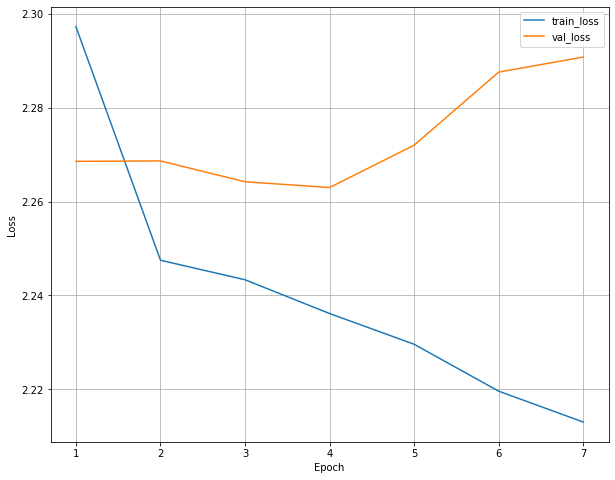

In [ ]:
fig, ax = plt.subplots(figsize = (10, 8))
plt.plot(history_epochs, history_loss, label = 'train_loss')
plt.plot(history_epochs, history_loss_val, label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid();

In [ ]:
dataset_test = ReviewMovieDataset(list(X_test), list(y_test), vocab)
test = DataLoader(dataset_test, batch_size = len(dataset_test), shuffle = True)

correct, total = 0, 0

model_simple.eval()
with torch.no_grad():
  for X_tst, y_tst in test:
    X_tst, y_tst = X_tst.to(device = device).float(), y_tst.to(device = device)

    out = model_simple(X_tst)
    _, predicted = torch.max(out, dim = 1)
    total += y_tst.shape[0]
    correct += int((predicted == y_tst).sum())

    f1 = f1_score(y_tst.to(device = 'cpu').numpy(), predicted.to(device = 'cpu').numpy(), average='weighted') # weighted, т.к. дисбаланс классов

f1_model_simple = f1
print(f'Accuracy = {correct/total}')
print(f'F1 = {f1}')

Accuracy = 0.30717284175944515
F1 = 0.15979338145925087


# Convalution

In [ ]:
class CNNReviewMovieNet(nn.Module):
  def __init__(self, vocab_size, embedding_dim, n_classes, pretrained_embeddings = []):
    super().__init__()

    if len(pretrained_embeddings) > 0:
      self.embeddings = nn.Embedding.from_pretrained(pretrained_embeddings)
    else:
      self.embeddings = nn.Embedding(vocab_size, embedding_dim)

    self.cnn1 = nn.Sequential(nn.Conv1d(embedding_dim, 1024, kernel_size = 2),
                                nn.BatchNorm1d(1024),
                                nn.ReLU(),
                                nn.MaxPool1d(2))
    
    self.cnn2 = nn.Sequential(nn.Conv1d(1024, 1024, 2),
                                nn.BatchNorm1d(1024),
                                nn.ReLU(),
                                nn.MaxPool1d(2))

    self.cnn3 = nn.Sequential(nn.Conv1d(1024, 512, 2),
                                nn.BatchNorm1d(512),
                                nn.ReLU(),
                                nn.MaxPool1d(2))
    
    self.fc = nn.Sequential(nn.Flatten(),
                            nn.Linear(512*419, 256), #839
                            nn.BatchNorm1d(256),
                            nn.ReLU(),
                            nn.Linear(256, 128),
                            nn.BatchNorm1d(128),
                            nn.Linear(128, 64),
                            nn.BatchNorm1d(64),
                            nn.ReLU(),
                            nn.Linear(64, 64),
                            nn.BatchNorm1d(64),
                            nn.ReLU(),
                            nn.Linear(64, n_classes))
    
  def forward(self, input):
    embed = self.embeddings(input).permute(0, 2, 1) 
    # print(embed.shape)
    out = self.cnn1(embed)
    out = self.cnn2(out)
    out = self.cnn3(out)
    # print(out.shape)
    out = self.fc(out)
    return out

In [ ]:
dataset_train = ReviewMovieDataset(list(X_train), list(y_train), vocab)

train_size = int(np.floor(0.8 * len(dataset_train)))
val_size = len(dataset_train) - train_size

train_dataset, test_dataset = random_split(dataset_train, [train_size, val_size])

train_data = DataLoader(train_dataset, batch_size = 32, shuffle = True)
validation = DataLoader(test_dataset, batch_size = 32, shuffle = True)

vocab_size = vocab.vocab_len
#hidden_size = 512
embedding_dim = 200
n_classes = df_work['Genre_label'].nunique()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_CNN  = CNNReviewMovieNet(vocab_size = vocab_size, embedding_dim = embedding_dim, n_classes = n_classes).to(device = device)
criteriation = nn.CrossEntropyLoss()
optimazer = optim.Adam(model_CNN.parameters(), lr = 0.001, weight_decay = 5*10**(-4))

early_stop = EarlyStopping(patience = 3, verbose = False, delta = 0.00001)

loss_history = list()
history_loss_val = list()
epochs_history = list()

n_epochs = 500

for epoch in range(1, n_epochs + 1):
  loss_batch = 0
  loss_val = 0

  for X_batch, y_batch in train_data:
    X_batch, y_batch = X_batch.to(device = device), y_batch.to(device = device)
    out = model_CNN(X_batch)

    cur_loss = criteriation(out, y_batch)
    loss_batch += cur_loss

    cur_loss.backward()
    optimazer.step()
    optimazer.zero_grad()

  loss_history.append(loss_batch/len(train_data))
  epochs_history.append(epoch)

  # model.eval()
  with torch.no_grad():
    for X_val, y_val in validation:
      X_val, y_val = X_val.to(device = device), y_val.to(device = device)
      out = model_CNN(X_val)

      loss = criteriation(out, y_val)
      loss_val += loss

  history_loss_val.append(loss_val/len(validation))

  if epoch % 2:
    print(f'Epoch: [{epoch}/{n_epochs}]: Loss_Train = {loss_history[-1]}, Loss_Val = {history_loss_val[-1]}')

  early_stop(history_loss_val[-1], model_CNN)

  if early_stop.early_stop: #and accuracy_val[-1] >= 0.7:
      print(f"Early stopping on epoch: [{epoch}/{n_epochs}] with Loss_Train = {loss_history[-1]}, Loss_Val = {history_loss_val[-1]}")
      break

torch.save(model_CNN, '/content/drive/MyDrive/models/DTZ_CNN_NotEmb.pth')

Epoch: [1/500]: Loss_Train = 2.293614387512207, Loss_Val = 2.182041645050049
Epoch: [3/500]: Loss_Train = 2.101457357406616, Loss_Val = 2.0538787841796875
Epoch: [5/500]: Loss_Train = 2.008213520050049, Loss_Val = 1.9874039888381958
Epoch: [7/500]: Loss_Train = 1.9218549728393555, Loss_Val = 1.9730830192565918
EarlyStopping counter: 1 out of 3
Epoch: [9/500]: Loss_Train = 1.737924337387085, Loss_Val = 1.8702833652496338
Epoch: [11/500]: Loss_Train = 1.4777159690856934, Loss_Val = 1.924179196357727
EarlyStopping counter: 1 out of 3
EarlyStopping counter: 2 out of 3
Epoch: [13/500]: Loss_Train = 1.2209513187408447, Loss_Val = 2.1251306533813477
EarlyStopping counter: 3 out of 3
Early stopping on epoch: [13/500] with Loss_Train = 1.2209513187408447, Loss_Val = 2.1251306533813477


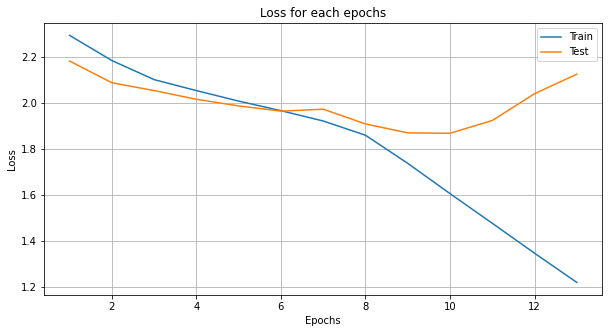

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(epochs_history, loss_history, label = 'Train')
plt.plot(epochs_history, history_loss_val, label = 'Test')
plt.legend()
plt.title('Loss for each epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()

In [ ]:
dataset_train = ReviewMovieDataset(list(X_test), list(y_test), vocab)
train_data = DataLoader(dataset_train, batch_size = 32, shuffle = True)

correct, total = 0, 0
f1 = list()

model_CNN.eval()
with torch.no_grad():
  for X_batch, y_batch in train_data:
    X_batch, y_batch = X_batch.to(device = device), y_batch.to(device = device)
    pred = model_CNN(X_batch)

    _, predicted = torch.max(pred, dim = 1)
    total += y_batch.shape[0]
    correct += int((predicted == y_batch).sum())

    f1_cur = f1_score(y_batch.to(device = 'cpu').numpy(), predicted.to(device = 'cpu').numpy(), average='weighted') # weighted, т.к. дисбаланс классов
    f1.append(f1_cur)

f1_CNN = sum(f1)/len(f1)
print(f'Accuracy = {correct/total}')
print(f'F1 = {f1_CNN}')

Accuracy = 0.38346413579120275
F1 = 0.3466898478073664


In [ ]:
torch.load('/content/drive/MyDrive/models/DTZ_CNN_NotEmb.pth', map_location = device)

CNNReviewMovieNet(
  (embeddings): Embedding(94095, 200)
  (cnn1): Sequential(
    (0): Conv1d(200, 1024, kernel_size=(2,), stride=(1,))
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn2): Sequential(
    (0): Conv1d(1024, 1024, kernel_size=(2,), stride=(1,))
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn3): Sequential(
    (0): Conv1d(1024, 512, kernel_size=(2,), stride=(1,))
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=214528, out_features=256, bi

# Recurrent layer

In [11]:
class RNNReviewMovieNet(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, n_classes, residual = 'RNN', pretrained_embeddings = []):
    super().__init__()

    if len(pretrained_embeddings) > 0:
      self.embeddings = nn.Embedding.from_pretrained(pretrained_embeddings)
    else:
      self.embeddings = nn.Embedding(vocab_size, embedding_dim)
    
    self.residual = residual.lower()

    if self.residual == 'rnn':
      self.rl = nn.RNN(input_size = embedding_dim, 
                        hidden_size = hidden_size,
                        num_layers = 2, 
                        nonlinearity = 'relu',
                        batch_first = True)
                        # dropout = 0.5)
      
    elif self.residual == 'lstm':
      self.rl = nn.LSTM(input_size = embedding_dim, 
                        hidden_size = hidden_size,
                        num_layers = 2,
                        batch_first = True)  
                        # dropout = 0.5)    

    elif self.residual == 'gru':
      self.rl = nn.GRU(input_size = embedding_dim, 
                        hidden_size = hidden_size,
                        num_layers = 2, 
                        batch_first = True) 
                        # dropout = 0.5)

    # self.fc = nn.Linear(hidden_size, n_classes)
    self.fc = nn.Sequential(nn.Flatten(),
                            nn.Linear(hidden_size, 512),
                            nn.BatchNorm1d(512),
                            nn.ReLU(),
                            nn.Linear(512, 256),
                            nn.BatchNorm1d(256),
                            nn.ReLU(),
                            nn.Linear(256, 128),
                            nn.BatchNorm1d(128),
                            nn.ReLU(),
                            nn.Linear(128, 64),
                            nn.BatchNorm1d(64),
                            nn.ReLU(),
                            nn.Linear(64, n_classes))
    
  def forward(self, input):
    embed = self.embeddings(input)
    # print(embed.shape)
    if self.residual == 'lstm':
      out, (hn, cn) = self.rl(embed)
      out = hn[0]
    else:
      out, hidden = self.rl(embed)
      out = hidden[0]
    # print(out.shape)
    out = self.fc(out)
    return out

RNN

In [ ]:
%%time
dataset_train = ReviewMovieDataset(list(X_train), list(y_train), vocab)

train_size = int(np.floor(0.8 * len(dataset_train)))
val_size = len(dataset_train) - train_size

train_dataset, test_dataset = random_split(dataset_train, [train_size, val_size])

train_data = DataLoader(train_dataset, batch_size = 64, shuffle = True)
validation = DataLoader(test_dataset, batch_size = 64, shuffle = True)

vocab_size = vocab.vocab_len
hidden_size = 128
embedding_dim = 100
n_classes = y_train.nunique()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_rnn  = RNNReviewMovieNet(vocab_size = vocab_size, 
                              embedding_dim = embedding_dim,
                              hidden_size = hidden_size,
                              n_classes = n_classes,
                              residual = 'rnn').to(device = device)

criteriation = nn.CrossEntropyLoss()
optimazer = optim.Adam(model_rnn.parameters(), lr = 0.001, weight_decay = 5*10**(-4))

early_stop = EarlyStopping(patience = 3, verbose = False, delta = 0)

loss_history = list()
history_loss_val = list()
epochs_history = list()
f1_val = list()

n_epochs = 500

for epoch in range(1, n_epochs + 1):
  loss_batch = 0
  loss_val = 0

  for X_batch, y_batch in train_data:
    X_batch, y_batch = X_batch.to(device = device), y_batch.to(device = device)
    out = model_rnn(X_batch)

    cur_loss = criteriation(out, y_batch)
    loss_batch += cur_loss

    cur_loss.backward()
    optimazer.step()
    optimazer.zero_grad()

  loss_history.append(loss_batch/len(train_data))
  epochs_history.append(epoch)

  f1 = list()
  with torch.no_grad():
    for X_val, y_val in validation:
      X_val, y_val = X_val.to(device = device), y_val.to(device = device)
      out = model_rnn(X_val)

      _, predicted = torch.max(out, dim = 1)

      loss = criteriation(out, y_val)
      loss_val += loss

      f1.append(f1_score(y_val.to(device = 'cpu').numpy(), predicted.to(device = 'cpu').numpy(), average='weighted'))

  history_loss_val.append(loss_val/len(validation))
  f1_val.append(sum(f1)/len(f1))

  if epoch % 2:
    print(f'Epoch: [{epoch}/{n_epochs}]: Loss_Train = {loss_history[-1]}, Loss_Val = {history_loss_val[-1]}, F1_Val = {f1_val[-1]}')

  early_stop(history_loss_val[-1], model_rnn)

  if early_stop.early_stop:
      print(f"Early stopping on epoch: [{epoch}/{n_epochs}] with Loss_Train = {loss_history[-1]}, Loss_Val = {history_loss_val[-1]}, F1_Val = {f1_val[-1]}")
      break

torch.save(model_rnn, '/content/drive/MyDrive/models/RNN_ReviewMoves_NotEmb.pth')

Epoch: [1/500]: Loss_Train = 2.526355028152466, Loss_Val = 2.3197808265686035, F1_Val = 0.14924183403551405
Epoch: [3/500]: Loss_Train = 2.2797152996063232, Loss_Val = 2.2765676975250244, F1_Val = 0.15019553011972936
EarlyStopping counter: 1 out of 3
Epoch: [5/500]: Loss_Train = 2.278440475463867, Loss_Val = 2.2781529426574707, F1_Val = 0.14910998577015508
EarlyStopping counter: 2 out of 3
EarlyStopping counter: 3 out of 3
Early stopping on epoch: [6/500] with Loss_Train = 2.275106191635132, Loss_Val = 2.280552864074707, F1_Val = 0.15019500181028575
CPU times: user 10min 38s, sys: 5.78 s, total: 10min 44s
Wall time: 10min 50s


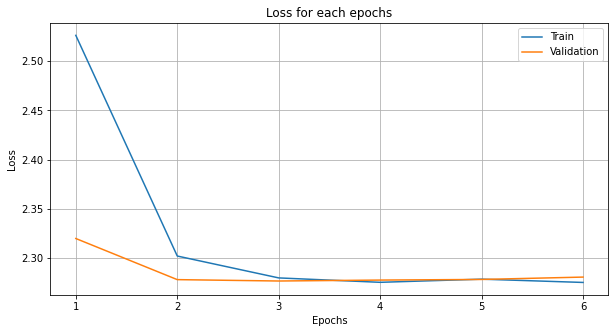

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(epochs_history, loss_history, label = 'Train')
plt.plot(epochs_history, history_loss_val, label = 'Validation')
plt.legend()
plt.title('Loss for each epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()

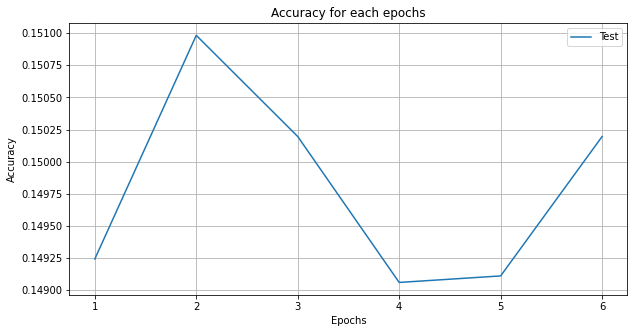

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(epochs_history, f1_val, label = 'Test')
plt.legend()
plt.title('Accuracy for each epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()

In [ ]:
dataset_train = ReviewMovieDataset(list(X_test), list(y_test), vocab)
train_data = DataLoader(dataset_train, batch_size = 32, shuffle = True)

correct, total = 0, 0
f1 = list()

# model_rnn.eval()
with torch.no_grad():
  for X_batch, y_batch in train_data:
    X_batch, y_batch = X_batch.to(device = device), y_batch.to(device = device)
    pred = model_rnn(X_batch)

    _, predicted = torch.max(pred, dim = 1)
    total += y_batch.shape[0]
    correct += int((predicted == y_batch).sum())

    f1.append(f1_score(y_batch.to(device = 'cpu').numpy(), predicted.to(device = 'cpu').numpy(), average='weighted')) # weighted, т.к. дисбаланс классов

f1_model_rnn = sum(f1)/len(f1)
print(f'Accuracy: {correct/total}')
print(f'F1: {f1_model_rnn}')

Accuracy: 0.3077203869319219
F1: 0.15031567033060833


LSTM

In [ ]:
dataset_train = ReviewMovieDataset(list(X_train), list(y_train), vocab)

train_size = int(np.floor(0.8 * len(dataset_train)))
val_size = len(dataset_train) - train_size

train_dataset, test_dataset = random_split(dataset_train, [train_size, val_size])

train_data = DataLoader(train_dataset, batch_size = 64, shuffle = True)
validation = DataLoader(test_dataset, batch_size = 64, shuffle = True)

vocab_size = vocab.vocab_len
hidden_size = 128
embedding_dim = 100
n_classes = y_train.nunique()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_lstm  = RNNReviewMovieNet(vocab_size = vocab_size, 
                                embedding_dim = embedding_dim,
                                hidden_size = hidden_size,
                                n_classes = n_classes,
                                residual = 'lstm').to(device = device)
criteriation = nn.CrossEntropyLoss()
optimazer = optim.Adam(model_lstm.parameters(), lr = 0.001, weight_decay = 5*10**(-4))

early_stop = EarlyStopping(patience = 3, verbose = False, delta = 0.00001)

loss_history = list()
history_loss_val = list()
epochs_history = list()
f1_val = list()

n_epochs = 500

for epoch in range(1, n_epochs + 1):
  loss_batch = 0
  loss_val = 0

  for X_batch, y_batch in train_data:
    X_batch, y_batch = X_batch.to(device = device), y_batch.to(device = device)
    out = model_lstm(X_batch)

    # print(f'out: {out.shape}') # batch_size * n_classes
    # print(f'y_batch: {y_batch.shape}') # batch_size * 1

    cur_loss = criteriation(out, y_batch)
    loss_batch += cur_loss

    cur_loss.backward()
    optimazer.step()
    optimazer.zero_grad()

  loss_history.append(loss_batch/len(train_data))
  epochs_history.append(epoch)

  f1 = list()
  with torch.no_grad():
    for X_val, y_val in validation:
      X_val, y_val = X_val.to(device = device), y_val.to(device = device)
      out = model_lstm(X_val)

      _, predicted = torch.max(out, dim = 1)

      loss = criteriation(out, y_val)
      loss_val += loss

      f1.append(f1_score(y_val.to(device = 'cpu').numpy(), predicted.to(device = 'cpu').numpy(), average='weighted'))

  history_loss_val.append(loss_val/len(validation))
  f1_val.append(sum(f1)/len(f1))

  if epoch % 2:
    print(f'Epoch: [{epoch}/{n_epochs}]: Loss_Train = {loss_history[-1]}, Loss_Val = {history_loss_val[-1]}, F1_Val = {f1_val[-1]}')

  early_stop(history_loss_val[-1], model_lstm)

  if early_stop.early_stop: #and accuracy_val[-1] >= 0.7:
      print(f"Early stopping on epoch: [{epoch}/{n_epochs}] with Loss_Train = {loss_history[-1]}, Loss_Val = {history_loss_val[-1]}, F1_Val = {f1_val[-1]}")
      break

torch.save(model_lstm, '/content/drive/MyDrive/models/LSTM_ReviewMoves_NotEmb.pth')

Epoch: [1/500]: Loss_Train = 2.4814035892486572, Loss_Val = 2.3692665100097656, F1_Val = 0.14134558690861657
Epoch: [3/500]: Loss_Train = 2.2959702014923096, Loss_Val = 2.243518114089966, F1_Val = 0.14399338450146376
Epoch: [5/500]: Loss_Train = 2.2902870178222656, Loss_Val = 2.241265296936035, F1_Val = 0.1414163758635673
EarlyStopping counter: 1 out of 3
EarlyStopping counter: 2 out of 3
Epoch: [7/500]: Loss_Train = 2.2868244647979736, Loss_Val = 2.2454371452331543, F1_Val = 0.14148161500362488
EarlyStopping counter: 3 out of 3
Early stopping on epoch: [7/500] with Loss_Train = 2.2868244647979736, Loss_Val = 2.2454371452331543, F1_Val = 0.14148161500362488


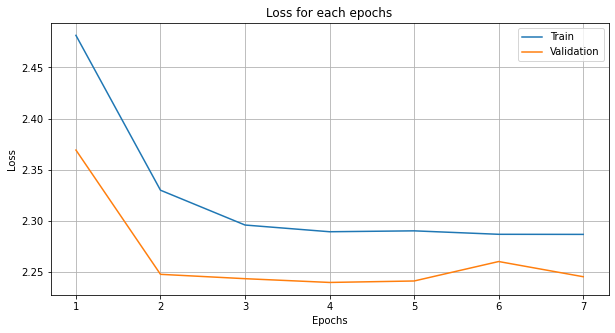

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(epochs_history, loss_history, label = 'Train')
plt.plot(epochs_history, history_loss_val, label = 'Validation')
plt.legend()
plt.title('Loss for each epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()

In [ ]:
dataset_train = ReviewMovieDataset(list(X_test), list(y_test), vocab)
train_data = DataLoader(dataset_train, batch_size = 32, shuffle = True)

correct, total = 0, 0
f1 = list()

# model_lstm.eval()
with torch.no_grad():
  for X_batch, y_batch in train_data:
    X_batch, y_batch = X_batch.to(device = device), y_batch.to(device = device)
    pred = model_lstm(X_batch)

    _, predicted = torch.max(pred, dim = 1)
    total += y_batch.shape[0]
    correct += int((predicted == y_batch).sum())

    f1.append(f1_score(y_batch.to(device = 'cpu').numpy(), predicted.to(device = 'cpu').numpy(), average='weighted')) # weighted, т.к. дисбаланс классов

f1_lstm = sum(f1)/len(f1)
print(f'Accuracy: {correct/total}')
print(f'F1: {f1_lstm}')

Accuracy: 0.3077203869319219
F1: 0.15100812296107735


GRU

In [ ]:
%%time
dataset_train = ReviewMovieDataset(list(X_train), list(y_train), vocab)

train_size = int(np.floor(0.8 * len(dataset_train)))
val_size = len(dataset_train) - train_size

train_dataset, test_dataset = random_split(dataset_train, [train_size, val_size])

train_data = DataLoader(train_dataset, batch_size = 32, shuffle = True)
validation = DataLoader(test_dataset, batch_size = 32, shuffle = True)

vocab_size = vocab.vocab_len
hidden_size = 128
embedding_dim = 100
n_classes = y_train.nunique()

model_gru  = RNNReviewMovieNet(vocab_size = vocab_size, 
                           embedding_dim = embedding_dim,
                           hidden_size = hidden_size,
                           n_classes = n_classes,
                           residual = 'gru').to(device = device)

criteriation = nn.CrossEntropyLoss()
optimazer = optim.Adam(model_gru.parameters(), lr = 0.001, weight_decay = 5*10**(-4))
early_stop = EarlyStopping(patience = 3, verbose = False, delta = 0.00001)

loss_history = list()
history_loss_val = list()
epochs_history = list()
f1_val = list()

n_epochs = 500

for epoch in range(1, n_epochs + 1):
  loss_batch = 0
  loss_val = 0

  for X_batch, y_batch in train_data:
    X_batch, y_batch = X_batch.to(device = device), y_batch.to(device = device)
    out = model_gru(X_batch)

    cur_loss = criteriation(out, y_batch)
    loss_batch += cur_loss

    cur_loss.backward()
    optimazer.step()
    optimazer.zero_grad()

  loss_history.append(loss_batch/len(train_data))
  epochs_history.append(epoch)

  f1 = list()
  with torch.no_grad():
    for X_val, y_val in validation:
      X_val, y_val = X_val.to(device = device), y_val.to(device = device)
      out = model_gru(X_val)

      _, predicted = torch.max(out, dim = 1)

      loss = criteriation(out, y_val)
      loss_val += loss

      f1.append(f1_score(y_val.to(device = 'cpu').numpy(), predicted.to(device = 'cpu').numpy(), average='weighted'))

  history_loss_val.append(loss_val/len(validation))
  f1_val.append(sum(f1)/len(f1))

  if epoch % 2:
    print(f'Epoch: [{epoch}/{n_epochs}]: Loss_Train = {loss_history[-1]}, Loss_Val = {history_loss_val[-1]}, F1_Val = {f1_val[-1]}')

  early_stop(history_loss_val[-1], model_gru)

  if early_stop.early_stop: #and accuracy_val[-1] >= 0.7:
      print(f"Early stopping on epoch: [{epoch}/{n_epochs}] with Loss_Train = {loss_history[-1]}, Loss_Val = {history_loss_val[-1]}, F1_Val = {f1_val[-1]}")
      break

torch.save(model_gru, '/content/drive/MyDrive/models/GRU_embedding_ReviewMoves_NotEmb.pth')

Epoch: [1/500]: Loss_Train = 2.346954345703125, Loss_Val = 2.2396655082702637, F1_Val = 0.1620755323518309
Epoch: [3/500]: Loss_Train = 2.1962668895721436, Loss_Val = 2.0902252197265625, F1_Val = 0.1810046676064746
Epoch: [5/500]: Loss_Train = 2.0540771484375, Loss_Val = 2.0503909587860107, F1_Val = 0.2063971129797815
Epoch: [7/500]: Loss_Train = 1.9063005447387695, Loss_Val = 1.9025617837905884, F1_Val = 0.31390693325606894
Epoch: [9/500]: Loss_Train = 1.580712080001831, Loss_Val = 1.8402348756790161, F1_Val = 0.3793149457108821
EarlyStopping counter: 1 out of 3
EarlyStopping counter: 2 out of 3
Epoch: [11/500]: Loss_Train = 1.2574249505996704, Loss_Val = 1.953307032585144, F1_Val = 0.4042786595513742
EarlyStopping counter: 3 out of 3
Early stopping on epoch: [11/500] with Loss_Train = 1.2574249505996704, Loss_Val = 1.953307032585144, F1_Val = 0.4042786595513742
CPU times: user 22min 7s, sys: 1min 36s, total: 23min 43s
Wall time: 23min 43s


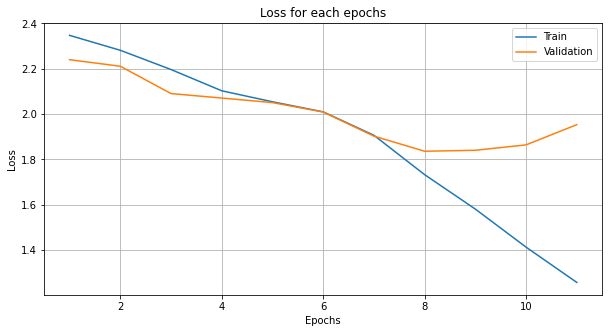

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(epochs_history, loss_history, label = 'Train')
plt.plot(epochs_history, history_loss_val, label = 'Validation')
plt.legend()
plt.title('Loss for each epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()

In [ ]:
dataset_train = ReviewMovieDataset(list(X_test), list(y_test), vocab)
train_data = DataLoader(dataset_train, batch_size = 32, shuffle = True)

correct, total = 0, 0
f1 = list()

# model_gru.eval()
with torch.no_grad():
  for X_batch, y_batch in train_data:
    X_batch, y_batch = X_batch.to(device = device), y_batch.to(device = device)
    pred = model_gru(X_batch)

    _, predicted = torch.max(pred, dim = 1)
    total += y_batch.shape[0]
    correct += int((predicted == y_batch).sum())

    f1.append(f1_score(y_batch.to(device = 'cpu').numpy(), predicted.to(device = 'cpu').numpy(), average='weighted')) # weighted, т.к. дисбаланс классов

f1_gru = sum(f1)/len(f1)
print(f'Accuracy: {correct/total}')
print(f'F1: {f1_gru}')

Accuracy: 0.4088337287826246
F1: 0.38285396377541453


# With Embedding

In [12]:
embedding_dim = 100
pretrained_embeddings = torch.rand(vocab.vocab_len, embedding_dim) # Инициализируем эмбединг случаыйными весами

with open('/content/drive/MyDrive/embeddings/glove.6B.100d.txt', 'r') as femb:
  for line in femb:
    token, *emb = line.split(' ')
    emb = torch.tensor([float(e) for e in emb], dtype = torch.float32)
    if token in vocab.token_to_idx.keys():
      pretrained_embeddings[vocab.token_to_idx[token]] = emb

Convolution

In [ ]:
%%time
dataset_train = ReviewMovieDataset(list(X_train), list(y_train), vocab)

train_size = int(np.floor(0.8 * len(dataset_train)))
val_size = len(dataset_train) - train_size

train_dataset, test_dataset = random_split(dataset_train, [train_size, val_size])

train_data = DataLoader(train_dataset, batch_size = 32, shuffle = True)
validation = DataLoader(test_dataset, batch_size = 32, shuffle = True)

vocab_size = vocab.vocab_len
# hidden_size = 512
# embedding_dim = 200
n_classes = df_work['Genre_label'].nunique()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_cnn_emb  = CNNReviewMovieNet(vocab_size = vocab_size, 
                                  embedding_dim = embedding_dim, 
                                  n_classes = n_classes,
                                  pretrained_embeddings = pretrained_embeddings.to(device = device)).to(device = device)

criteriation = nn.CrossEntropyLoss()
optimazer = optim.Adam(model_cnn_emb.parameters(), lr = 0.001, weight_decay = 5*10**(-4))

early_stop = EarlyStopping(patience = 3, verbose = False, delta = 0.00001)

loss_history = list()
history_loss_val = list()
f1_val = list()
epochs_history = list()

n_epochs = 500

for epoch in range(1, n_epochs + 1):
  loss_batch = 0
  loss_val = 0

  for X_batch, y_batch in train_data:
    X_batch, y_batch = X_batch.to(device = device), y_batch.to(device = device)
    out = model_cnn_emb(X_batch)

    cur_loss = criteriation(out, y_batch)
    loss_batch += cur_loss

    cur_loss.backward()
    optimazer.step()
    optimazer.zero_grad()

  loss_history.append(loss_batch/len(train_data))
  epochs_history.append(epoch)

  f1 = list()
  with torch.no_grad():
    for X_val, y_val in validation:
      X_val, y_val = X_val.to(device = device), y_val.to(device = device)
      out = model_cnn_emb(X_val)

      _, predicted = torch.max(out, dim = 1)

      loss = criteriation(out, y_val)
      loss_val += loss

      f1.append(f1_score(y_val.to(device = 'cpu').numpy(), predicted.to(device = 'cpu').numpy(), average='weighted'))

  history_loss_val.append(loss_val/len(validation))
  f1_val.append(sum(f1)/len(f1))

  if epoch % 2:
    print(f'Epoch: [{epoch}/{n_epochs}]: Loss_Train = {loss_history[-1]}, Loss_Val = {history_loss_val[-1]}, F1_Val = {f1_val[-1]}')

  early_stop(history_loss_val[-1], model_cnn_emb)

  if early_stop.early_stop: #and accuracy_val[-1] >= 0.7:
      print(f"Early stopping on epoch: [{epoch}/{n_epochs}] with Loss_Train = {loss_history[-1]}, Loss_Val = {history_loss_val[-1]}, F1_Val = {f1_val[-1]}")
      break

torch.save(model_cnn_emb, '/content/drive/MyDrive/models/DTZ_CNN_WithEmb.pth')

Epoch: [1/500]: Loss_Train = 2.2335550785064697, Loss_Val = 2.094512939453125, F1_Val = 0.23018243896181123
Epoch: [3/500]: Loss_Train = 1.9346939325332642, Loss_Val = 1.9169667959213257, F1_Val = 0.27724766122125655
Epoch: [5/500]: Loss_Train = 1.7960116863250732, Loss_Val = 1.8087983131408691, F1_Val = 0.31877744773310895
Epoch: [7/500]: Loss_Train = 1.698760747909546, Loss_Val = 1.7479736804962158, F1_Val = 0.35070196625558203
Epoch: [9/500]: Loss_Train = 1.5986469984054565, Loss_Val = 1.6736130714416504, F1_Val = 0.38067269346676086
EarlyStopping counter: 1 out of 3
Epoch: [11/500]: Loss_Train = 1.5370733737945557, Loss_Val = 1.673439383506775, F1_Val = 0.3835130343457558
EarlyStopping counter: 1 out of 3
Epoch: [13/500]: Loss_Train = 1.4789067506790161, Loss_Val = 1.7093148231506348, F1_Val = 0.3908817265355092
EarlyStopping counter: 2 out of 3
EarlyStopping counter: 3 out of 3
Early stopping on epoch: [14/500] with Loss_Train = 1.4410475492477417, Loss_Val = 1.7165569067001343, F

In [ ]:
dataset_train = ReviewMovieDataset(list(X_test), list(y_test), vocab)
train_data = DataLoader(dataset_train, batch_size = 32, shuffle = True)

correct, total = 0, 0
f1 = list()

# model_cnn_emb.eval()
with torch.no_grad():
  for X_batch, y_batch in train_data:
    X_batch, y_batch = X_batch.to(device = device), y_batch.to(device = device)
    pred = model_cnn_emb(X_batch)

    _, predicted = torch.max(pred, dim = 1)
    total += y_batch.shape[0]
    correct += int((predicted == y_batch).sum())

    f1.append(f1_score(y_batch.to(device = 'cpu').numpy(), predicted.to(device = 'cpu').numpy(), average='weighted')) # weighted, т.к. дисбаланс классов

f1_CNN_emb = sum(f1)/len(f1)
print(f'Accuracy: {correct/total}')
print(f'F1: {f1_CNN_emb}')

Accuracy: 0.42069720751962036
F1: 0.3948141899339871


RNN

In [14]:
%%time
dataset_train = ReviewMovieDataset(list(X_train), list(y_train), vocab)

train_size = int(np.floor(0.8 * len(dataset_train)))
val_size = len(dataset_train) - train_size

train_dataset, test_dataset = random_split(dataset_train, [train_size, val_size])

train_data = DataLoader(train_dataset, batch_size = 64, shuffle = True)
validation = DataLoader(test_dataset, batch_size = 64, shuffle = True)

vocab_size = vocab.vocab_len
hidden_size = 128
# embedding_dim = 128
n_classes = df_work['Genre_label'].nunique()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_rnn_emb  = RNNReviewMovieNet(vocab_size = vocab_size, 
                           embedding_dim = embedding_dim,
                           hidden_size = hidden_size,
                           n_classes = n_classes,
                           residual = 'rnn',
                           pretrained_embeddings = pretrained_embeddings).to(device = device)

criteriation = nn.CrossEntropyLoss()
optimazer = optim.Adam(model_rnn_emb.parameters(), lr = 0.001, weight_decay = 5*10**(-4))

early_stop = EarlyStopping(patience = 3, verbose = False, delta = 0)

loss_history = list()
history_loss_val = list()
epochs_history = list()
f1_val = list()

n_epochs = 500

for epoch in range(1, n_epochs + 1):
  loss_batch = 0
  loss_val = 0

  for X_batch, y_batch in train_data:
    X_batch, y_batch = X_batch.to(device = device), y_batch.to(device = device)
    out = model_rnn_emb(X_batch)

    cur_loss = criteriation(out, y_batch)
    loss_batch += cur_loss

    cur_loss.backward()
    optimazer.step()
    optimazer.zero_grad()


  loss_history.append(loss_batch/len(train_data))
  epochs_history.append(epoch)

  f1 = list()
  with torch.no_grad():
    for X_val, y_val in validation:
      X_val, y_val = X_val.to(device = device), y_val.to(device = device)
      out = model_rnn_emb(X_val)

      _, predicted = torch.max(out, dim = 1)

      loss = criteriation(out, y_val)
      loss_val += loss
      
      f1.append(f1_score(y_val.to(device = 'cpu').numpy(), predicted.to(device = 'cpu').numpy(), average='weighted'))
  
  history_loss_val.append(loss_val/len(validation))
  f1_val.append(sum(f1)/len(f1))

  if epoch % 2:
    print(f'Epoch: [{epoch}/{n_epochs}]: Loss_Train = {loss_history[-1]}, Loss_Val = {history_loss_val[-1]}, F1_Val = {f1_val[-1]}')

  early_stop(history_loss_val[-1], model_rnn_emb)

  if early_stop.early_stop:
      print(f"Early stopping on epoch: [{epoch}/{n_epochs}] with Loss_Train = {loss_history[-1]}, Loss_Val = {history_loss_val[-1]}, F1_Val = {f1_val[-1]}")
      break

torch.save(model_rnn_emb, '/content/drive/MyDrive/models/RNN_ReviewMoves_Emb.pth')

Epoch: [1/500]: Loss_Train = 2.4872567653656006, Loss_Val = 2.5464019775390625, F1_Val = 0.14846245923160456
Epoch: [3/500]: Loss_Train = 2.296778678894043, Loss_Val = 2.3140182495117188, F1_Val = 0.15147354002361266
Epoch: [5/500]: Loss_Train = 2.277759313583374, Loss_Val = 2.2798712253570557, F1_Val = 0.14922467923930938
EarlyStopping counter: 1 out of 3
EarlyStopping counter: 2 out of 3
Epoch: [7/500]: Loss_Train = 2.278136730194092, Loss_Val = 2.2860045433044434, F1_Val = 0.14924975397203538
EarlyStopping counter: 3 out of 3
Early stopping on epoch: [7/500] with Loss_Train = 2.278136730194092, Loss_Val = 2.2860045433044434, F1_Val = 0.14924975397203538
CPU times: user 12min 53s, sys: 1min 36s, total: 14min 29s
Wall time: 14min 28s


In [15]:
dataset_train = ReviewMovieDataset(list(X_test), list(y_test), vocab)
train_data = DataLoader(dataset_train, batch_size = 32, shuffle = True)

correct, total = 0, 0
f1 = list()

# model_rnn_emb.eval()
with torch.no_grad():
  for X_batch, y_batch in train_data:
    X_batch, y_batch = X_batch.to(device = device), y_batch.to(device = device)
    pred = model_rnn_emb(X_batch)

    _, predicted = torch.max(pred, dim = 1)
    total += y_batch.shape[0]
    correct += int((predicted == y_batch).sum())

    f1.append(f1_score(y_batch.to(device = 'cpu').numpy(), predicted.to(device = 'cpu').numpy(), average='weighted')) # weighted, т.к. дисбаланс классов

f1_rnn_emb = sum(f1)/len(f1)
print(f'Accuracy: {correct/total}')
print(f'F1: {f1_rnn_emb}')

Accuracy: 0.3077203869319219
F1: 0.15485916398803926


LSTM

In [16]:
%%time
dataset_train = ReviewMovieDataset(list(X_train), list(y_train), vocab)

train_size = int(np.floor(0.8 * len(dataset_train)))
val_size = len(dataset_train) - train_size

train_dataset, test_dataset = random_split(dataset_train, [train_size, val_size])

train_data = DataLoader(train_dataset, batch_size = 64, shuffle = True)
validation = DataLoader(test_dataset, batch_size = 64, shuffle = True)

vocab_size = vocab.vocab_len
hidden_size = 128
# embedding_dim = 50
n_classes = df_work['Genre_label'].nunique()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_lstm_emb  = RNNReviewMovieNet(vocab_size = vocab_size, 
                           embedding_dim = embedding_dim,
                           hidden_size = hidden_size,
                           n_classes = n_classes,
                           residual = 'lstm',
                           pretrained_embeddings = pretrained_embeddings).to(device = device)

criteriation = nn.CrossEntropyLoss()
optimazer = optim.Adam(model_lstm_emb.parameters(), lr = 0.001, weight_decay = 5*10**(-4))

early_stop = EarlyStopping(patience = 4, verbose = False, delta = 0.0001)

loss_history = list()
history_loss_val = list()
epochs_history = list()
f1_val = list()

n_epochs = 500

for epoch in range(1, n_epochs + 1):
  loss_batch = 0
  loss_val = 0

  for X_batch, y_batch in train_data:
    X_batch, y_batch = X_batch.to(device = device), y_batch.to(device = device)
    out = model_lstm_emb(X_batch)

    cur_loss = criteriation(out, y_batch)
    loss_batch += cur_loss

    cur_loss.backward()
    optimazer.step()
    optimazer.zero_grad()

  loss_history.append(loss_batch/len(train_data))
  epochs_history.append(epoch)

  f1 = list()
  with torch.no_grad():
    for X_val, y_val in validation:
      X_val, y_val = X_val.to(device = device), y_val.to(device = device)
      out = model_lstm_emb(X_val)

      _, predicted = torch.max(out, dim = 1)

      loss = criteriation(out, y_val)
      loss_val += loss

      f1.append(f1_score(y_val.to(device = 'cpu').numpy(), predicted.to(device = 'cpu').numpy(), average='weighted'))

  history_loss_val.append(loss_val/len(validation))
  f1_val.append(sum(f1)/len(f1))

  if epoch % 2:
    print(f'Epoch: [{epoch}/{n_epochs}]: Loss_Train = {loss_history[-1]}, Loss_Val = {history_loss_val[-1]}, F1_Val = {f1_val[-1]}')

  early_stop(history_loss_val[-1], model_lstm_emb)

  if early_stop.early_stop: #and accuracy_val[-1] >= 0.7:
      print(f"Early stopping on epoch: [{epoch}/{n_epochs}] with Loss_Train = {loss_history[-1]}, Loss_Val = {history_loss_val[-1]}, F1_Val = {f1_val[-1]}")
      break

torch.save(model_lstm_emb, '/content/drive/MyDrive/models/LSTM_ReviewMoves_Emb.pth')

Epoch: [1/500]: Loss_Train = 2.4267663955688477, Loss_Val = 2.365468740463257, F1_Val = 0.1499658033154389
Epoch: [3/500]: Loss_Train = 2.2920022010803223, Loss_Val = 2.2804877758026123, F1_Val = 0.15075165554959138
Epoch: [5/500]: Loss_Train = 2.276071071624756, Loss_Val = 2.278791904449463, F1_Val = 0.15023382838136606
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
Epoch: [7/500]: Loss_Train = 2.274728536605835, Loss_Val = 2.278928518295288, F1_Val = 0.14966730805611275
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping on epoch: [8/500] with Loss_Train = 2.2736237049102783, Loss_Val = 2.281054735183716, F1_Val = 0.15058074871112512
CPU times: user 17min, sys: 4min 5s, total: 21min 6s
Wall time: 21min 5s


In [17]:
dataset_train = ReviewMovieDataset(list(X_test), list(y_test), vocab)
train_data = DataLoader(dataset_train, batch_size = 32, shuffle = True)

correct, total = 0, 0
f1 = list()

# model_lstm_emb.eval()
with torch.no_grad():
  for X_batch, y_batch in train_data:
    X_batch, y_batch = X_batch.to(device = device), y_batch.to(device = device)
    pred = model_lstm_emb(X_batch)

    _, predicted = torch.max(pred, dim = 1)
    total += y_batch.shape[0]
    correct += int((predicted == y_batch).sum())

    f1.append(f1_score(y_batch.to(device = 'cpu').numpy(), predicted.to(device = 'cpu').numpy(), average='weighted')) # weighted, т.к. дисбаланс классов

f1_lstm_emb = sum(f1)/len(f1) 
print(f'Accuracy: {correct/total}')
print(f'F1: {f1_lstm_emb}')

Accuracy: 0.3077203869319219
F1: 0.15191795209376022


GRU

In [18]:
%%time
dataset_train = ReviewMovieDataset(list(X_train), list(y_train), vocab)

train_size = int(np.floor(0.8 * len(dataset_train)))
val_size = len(dataset_train) - train_size

train_dataset, test_dataset = random_split(dataset_train, [train_size, val_size])

train_data = DataLoader(train_dataset, batch_size = 64, shuffle = True)
validation = DataLoader(test_dataset, batch_size = 64, shuffle = True)

vocab_size = vocab.vocab_len
hidden_size = 128
n_classes = df_work['Genre_label'].nunique()

model_gru_emb  = RNNReviewMovieNet(vocab_size = vocab_size, 
                                  embedding_dim = embedding_dim,
                                  hidden_size = hidden_size,
                                  n_classes = n_classes,
                                  residual = 'gru').to(device = device)

criteriation = nn.CrossEntropyLoss()
optimazer = optim.Adam(model_gru_emb.parameters(), lr = 0.001, weight_decay = 5*10**(-4))

early_stop = EarlyStopping(patience = 3, verbose = False, delta = 0.0001)

loss_history = list()
history_loss_val = list()
epochs_history = list()
f1_val = list()

n_epochs = 500

for epoch in range(1, n_epochs + 1):
  loss_batch = 0
  loss_val = 0

  for X_batch, y_batch in train_data:
    X_batch, y_batch = X_batch.to(device = device), y_batch.to(device = device)
    out = model_gru_emb(X_batch)

    cur_loss = criteriation(out, y_batch)
    loss_batch += cur_loss

    cur_loss.backward()
    optimazer.step()
    optimazer.zero_grad()

  loss_history.append(loss_batch/len(train_data))
  epochs_history.append(epoch)

  f1 = list()
  with torch.no_grad():
    for X_val, y_val in validation:
      X_val, y_val = X_val.to(device = device), y_val.to(device = device)
      out = model_gru_emb(X_val)

      _, predicted = torch.max(out, dim = 1)

      loss = criteriation(out, y_val)
      loss_val += loss

      f1.append(f1_score(y_val.to(device = 'cpu').numpy(), predicted.to(device = 'cpu').numpy(), average='weighted'))

  history_loss_val.append(loss_val/len(validation))
  f1_val.append(sum(f1)/len(f1))

  if epoch % 2:
    print(f'Epoch: [{epoch}/{n_epochs}]: Loss_Train = {loss_history[-1]}, Loss_Val = {history_loss_val[-1]}, F1_Val = {f1_val[-1]}')

  early_stop(history_loss_val[-1], model_gru_emb)

  if early_stop.early_stop: #and accuracy_val[-1] >= 0.7:
      print(f"Early stopping on epoch: [{epoch}/{n_epochs}] with Loss_Train = {loss_history[-1]}, Loss_Val = {history_loss_val[-1]}, F1_Val = {f1_val[-1]}")
      break

torch.save(model_gru_emb, '/content/drive/MyDrive/models/GRU_embedding_ReviewMoves_Emb.pth')

Epoch: [1/500]: Loss_Train = 2.42561411857605, Loss_Val = 2.3096840381622314, F1_Val = 0.19111859359974617
EarlyStopping counter: 1 out of 3
Epoch: [3/500]: Loss_Train = 2.2863893508911133, Loss_Val = 2.283573627471924, F1_Val = 0.14799923550042546
Epoch: [5/500]: Loss_Train = 2.2470717430114746, Loss_Val = 2.237508535385132, F1_Val = 0.15018880394032988
Epoch: [7/500]: Loss_Train = 2.1040704250335693, Loss_Val = 2.085963487625122, F1_Val = 0.17304310761481442
Epoch: [9/500]: Loss_Train = 1.957594633102417, Loss_Val = 2.0056025981903076, F1_Val = 0.2473589423814095
Epoch: [11/500]: Loss_Train = 1.7007887363433838, Loss_Val = 1.8437879085540771, F1_Val = 0.3367652902896416
EarlyStopping counter: 1 out of 3
Epoch: [13/500]: Loss_Train = 1.435072898864746, Loss_Val = 1.9277054071426392, F1_Val = 0.36340546462379114
EarlyStopping counter: 2 out of 3
EarlyStopping counter: 3 out of 3
Early stopping on epoch: [14/500] with Loss_Train = 1.3021774291992188, Loss_Val = 2.0029265880584717, F1_Va

In [19]:
dataset_train = ReviewMovieDataset(list(X_test), list(y_test), vocab)
train_data = DataLoader(dataset_train, batch_size = 32, shuffle = True)

correct, total = 0, 0
f1 = list()

# model_gru_emb.eval()
with torch.no_grad():
  for X_batch, y_batch in train_data:
    X_batch, y_batch = X_batch.to(device = device), y_batch.to(device = device)
    pred = model_gru_emb(X_batch)

    _, predicted = torch.max(pred, dim = 1)
    total += y_batch.shape[0]
    correct += int((predicted == y_batch).sum())

    f1.append(f1_score(y_batch.to(device = 'cpu').numpy(), predicted.to(device = 'cpu').numpy(), average='weighted')) # weighted, т.к. дисбаланс классов

f1_gru_emb = sum(f1)/len(f1)
print(f'Accuracy: {correct/total}')
print(f'F1: {f1_gru_emb}')

Accuracy: 0.3807264099288191
F1: 0.3556115310589077


# Структура моделей

In [25]:
device

device(type='cuda')

In [37]:
torch.load('/content/drive/MyDrive/models/RNN_ReviewMoves_Emb.pth', map_location = device)

RNNReviewMovieNet(
  (embeddings): Embedding(93598, 100)
  (rl): RNN(100, 128, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128, out_features=512, bias=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Linear(in_features=256, out_features=128, bias=True)
    (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=64, bias=True)
    (11): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Linear(in_features=64, out_features=20, bias=True)
  )
)

In [35]:
torch.load('/content/drive/MyDrive/models/LSTM_ReviewMoves_Emb.pth', map_location = device)

RNNReviewMovieNet(
  (embeddings): Embedding(93598, 100)
  (rl): LSTM(100, 128, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128, out_features=512, bias=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Linear(in_features=256, out_features=128, bias=True)
    (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=64, bias=True)
    (11): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Linear(in_features=64, out_features=20, bias=True)
  )
)

In [36]:
torch.load('/content/drive/MyDrive/models/GRU_embedding_ReviewMoves_Emb.pth', map_location = device)

RNNReviewMovieNet(
  (embeddings): Embedding(93598, 100)
  (rl): GRU(100, 128, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128, out_features=512, bias=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Linear(in_features=256, out_features=128, bias=True)
    (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=64, bias=True)
    (11): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Linear(in_features=64, out_features=20, bias=True)
  )
)